# Ultimate Challenge

Please see the link below for a short description of the raw data and the problem of interest:
https://github.com/jingzhaomirror/Springboard_ultimate_challenge/blob/master/ultimate_data_science_challenge.pdf

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# Part I. EDA of user logins

## 1. Import data and basic wrangling

In [2]:
with open('logins.json') as f:
    data = json.load(f)

login = pd.DataFrame(data)

In [3]:
login.info()
login.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10


In [4]:
login.describe()

,login_time
count,93142
unique,92265
top,1970-02-24 23:09:57
freq,3


As shown, there is no missing values, but some duplicated timestamps, especiallly there are 3 entries of the same timestamp of "1970-02-24 23:09:57". Without further information on how the data was collected and how frequently a user can login to their account , it's hard to say if these duplicated entries are valid or not. For the following analysis, we will treat them as valid entries. 

In [5]:
# convert 'login_time' column as datetime format and sort in ascending order
login['login_time'] = pd.to_datetime(login.login_time, format="%Y-%m-%d")
login = login.sort_values('login_time')
login.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


As shown, the original data was not ordered by the timestamp completely. 

## 2. Aggregate counts based on 15-minute intervals

In [6]:
login['count'] = 1
login = login.set_index('login_time') # set 'login_time' as the DateTime index

In [7]:
# resample these login counts based on 15-minute time intervals
login = login.resample('15T').sum()

In [8]:
login.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


## 3. Visualizing login patterns and trends

### 3.1 Histogram

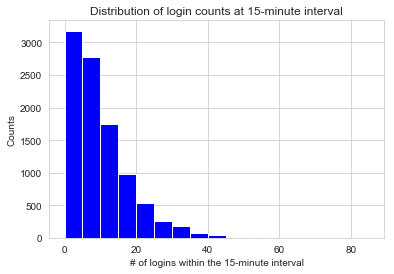

In [9]:
# understand the basic distribution of login counts at 15-minute intervals
login['count'].plot(kind='hist',bins=np.arange(0,90,5),color='blue',title="Distribution of login counts at 15-minute interval");
plt.xlabel("# of logins within the 15-minute interval");
plt.ylabel("Counts");

As shown, most of the login counts at 15-minute interval are in the range of 0-20. <br> 

### 3.2 Plot the time series

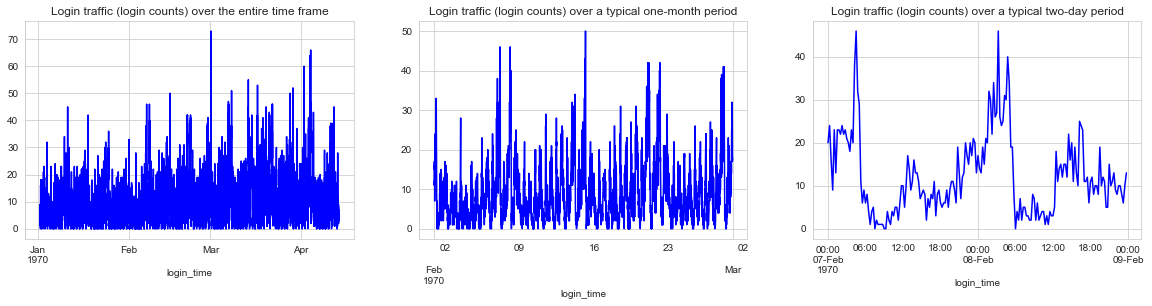

In [10]:
# plot the time series data
plt.figure(figsize=(20,4));
ax1 = plt.subplot(1,3,1)
login.plot(ax=ax1,color='blue',title='Login traffic (login counts) over the entire time frame',legend=False);
ax2 = plt.subplot(1,3,2)
login['1970-02'].plot(ax=ax2,color='blue',title='Login traffic (login counts) over a typical one-month period',legend=False);
ax3 = plt.subplot(1,3,3)
login['1970-02-07':'1970-02-08'].plot(ax=ax3,color='blue', title='Login traffic (login counts) over a typical two-day period',legend=False);

The time series trends of login counts at 15-minute interval shows a clear daily cycle and a weekly cycle on top of that, which we will take a deeper look at.<br>

### 3.3 Cyclic patterns

In [11]:
# extract time features from datetime index
login['month'] = login.index.month
login['week'] = login.index.week
login['day'] = login.index.day
login['hour'] = login.index.hour
login['dayofweek'] = login.index.dayofweek

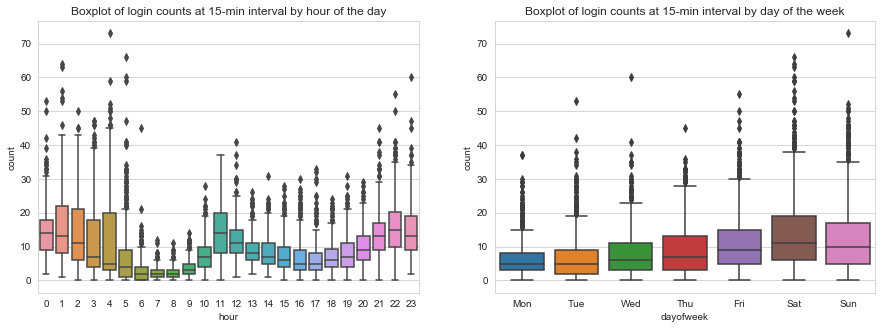

In [12]:
# boxplot showing daily and weekly cycles

plt.figure(figsize=(15,5))
# daily cycles
ax1 = plt.subplot(1,2,1)
sns.boxplot(x='hour',y='count',data=login,ax=ax1);
ax1.set_title('Boxplot of login counts at 15-min interval by hour of the day');
# weekly cycles
ax2 = plt.subplot(1,2,2)
sns.boxplot(x='dayofweek',y='count',data=login,ax=ax2);
ax2.set_title('Boxplot of login counts at 15-min interval by day of the week');
ax2.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

As shown, the counts show clear cyclic patterns:<br>
1) daily pattern: the login count at 15-minute intervals starts off the day from its daily lowest in the early morning (6am-9am), bounches up to its first spike around lunch time (11am-12pm), followed by a graduate decline in the afternoon till 5pm; it gradually rises back up in the early evening and reaches its second peak in late evening to midnight (21pm-2am). The high counts also show wider distributions in general.<br>
2) weekly pattern: the login count at 15-minute intervals sees the lowest on Monday, and gradually ramps up throughout the week, and reaches its peak on weekends. Login counts on Saturday are slightly higher than those on Sunday. Again, the higher counts are associated with wider distributions.<br>

However, it's possible that the daily pattern differs between weekdays and weekends. Therefore, a 2D heatmap might reveal more insights on the interplay between daily cycles and weekly cycles.

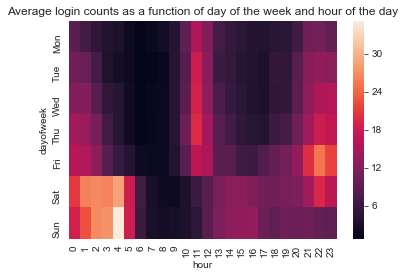

In [13]:
# pivot 'login' dataframe by 'dayofweek' as the index and 'hour' as the column, average the login counts at the values
login_p = pd.pivot_table(login, index='dayofweek',columns='hour',values='count',aggfunc='mean')
login_p.head(2)

# plot the heatmap
ax = sns.heatmap(login_p);
ax.set_title("Average login counts as a function of day of the week and hour of the day");
ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

As shown, two distinct daily cycles are observed on weekdays $vs.$ weekends:<br>
1) weekdays: the login counts spike before lunch at 11am and late evening 22-23pm, and dips early mornig around 6-8am, and in the afternoon around 16-17pm. On average, the counts are at the lowest on Monday and highest on Friday during weekdays.<br>
2) weekends: the login counts reach its peak after midnight around 1am-5am, and dips in the late morning around 8-10am, whereas the entire afternoon and evening see moderate login activities.<br>
(note: this underlying weekend pattern was shaddowed earlier due to the small ratio of weekend days vs weekdays.)

### 3.4 Trends over time

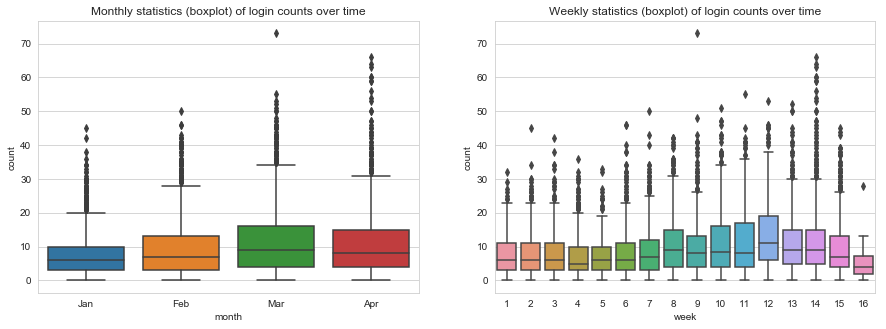

In [14]:
# boxplot showing trends over time
plt.figure(figsize=(15,5))
# monthly statistics over time
ax1 = plt.subplot(1,2,1)
sns.boxplot(x='month',y='count',data=login,ax=ax1);
ax1.set_title('Monthly statistics (boxplot) of login counts over time');
ax1.set_xticklabels(['Jan','Feb','Mar','Apr']);
# weekly statistics over time
ax2 = plt.subplot(1,2,2)
sns.boxplot(x='week',y='count',data=login,ax=ax2);
ax2.set_title('Weekly statistics (boxplot) of login counts over time');

As shown, the login counts at 15-minute interval rise from January to March, followed by a decline in April. This trend over time is even more promininent when looking at the chart of weekly statistics of login counts.<br>
The continuous rise in login counts from January to early March (week 1 to 12) shows a good sign of improving user engagement. However, the significant decline in week 15 & 16 (April) might indicate some serious problems, which definitely worth looking into. 

# Part 2. Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.<br>
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

## 1 What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

**First we need to find two groups of driver partners:** <br>
Group A): driver partners exclusive to city 'Gotham' <br>
Group B): driver partners exclusive to city 'Metropolis'<br>

**My proposed key measure of success is:**<br>
1) the increased time spend in city 'Metropolis' by group A drivers (drivers associated with 'Gotham')<br>
2) the increased time spend in city 'Gotham' by group B drivers (drivers associated with 'Metropolis')<br>
We should track both groups because this proposed experiment might only have an effect on one of the groups.<br>

**Reasons:**<br>
**1) this is an effective measure of whether driver partners are serving both cities or not:**<br>
If drivers are serving both cities, they must spend time in both cities. For drivers previously exclusive to 'Gotham', they must spend more time in 'Metropolis' if they start to serve both cities, and vise versa. <br>

**2) when compared with other effective measures, this is among the easiest-to-collect metric, because it doesn't require additional infrastructures, equipments and policies to be implemented:**<br>

Assuming that the toll stations at the two-way toll bridge already keep a record of the toll amount, the driver/vehicle identify (driver ID, or vehicle license plate) and the corresponding timestamp everytime a toll is collected. We can easily compute the time a particular driver spend in a city by looking at the two adjacent toll collection entries of that driver (e.g.: subtracting the timestamp of toll collected in direction 'Gotham'--> 'Metropolis' from the next timestamp of toll collected in direction 'Metropolis'-->'Gotham' is the time the driver spend in city 'Metropolis' during that trip. <br>

Therefore, this metric can be obtained based on the existing recording system at the toll bridge. Whereas other more direct measures such as tracking picking up and dropping off locations of driver partners will require installing additional location-tracking devices, and drivers' agreement on participation (being tracked).<br>

## 2 Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

**a) how you will implement the experiment?**<br>

- First, based on the current toll records, we need to devide the driver partners into two groups proposed above by analyzing the time drivers spent in each city. In particular, we are interested in drivers currently mostly exclusive to city 'Gotham' as group A, and driver currently mostly exclusive to city 'Metropolis' as group B.<br>
note: There could be a third group (group C) for drivers currently already serving both cities, depending on the scope of the experiment and the resources (money and labor) available to the experiment. <br>
- Secondly, for each group, we will split the group in half randomly. Reach out to the picked drivers in the group (e.g. when they pass the toll-bridge) and provide them with the toll reimbursement offer.<br>
- Lastly, for each group, we look at the toll records for all drivers in the group after half of them (the experiment) have been given the offer, and compare their statistics (the time drivers spend in their non-associated city) to see if the difference between the experient and the control is statistically significant.

**b) what statistical test(s) you will conduct to verify the significance of the observation?**<br>

By dividing each group of drivers randomly in half, we can conduct a A/B test. This allows us to evaluate the key metric for each group by comparing the experiment $vs.$ control with the toll reimbursement offer as the only variable. In particular, this allows a comparison within exactly the same timeframe, as workday vs. weekend and weather condition all have an impact on drivers activity.<br>

After enough data are collected, we will compute a two-sample t statistic to determine if the average time drivers spend in their non-associated city is significant different between the experiment vs control.<br> 
* Significance level: 0.05 (or even 0.01)<br>
* Null hypothesis is: $$H_0: \mu_(experiment) - \mu_(control) = 0$$ 
* Alternative hypothesis is: $$H_a: \mu_(experiment) - \mu_(control) > 0$$

We will compute the t-statistics and use $t$ table to find the p-value and draw conclusion.

**c) how you would interpret the results and provide recommendations to the city operations team along with any caveats:**<br>

The interpretation depends on the p-value concluded from the above t-tests for each group.<br> 
If p-value is smaller than the significance level for both group A and B, the experiment and the results along with the confidence level and the power of the statistical tests should be present to the city operation team, so they can make an informed decision on whether to implement the toll reimbursement strategy or not. <br>

The potential caveats are: <br>
* the difference is only significant during weekdays, but not on weekends:<br>
This is entirely possible given that, there is reasonable activity in both cities on weekends, and the drivers have enough riders by staying only in one city.<br>
* the difference is only significant in one group:<br>
This is also possible. For instance, city 'Gotham' is mostly active at night. Without bridge toll, drivers associated with city 'Gotham' might be willing to go to city 'Metropolis' during the day for more riders, resulting in a significant difference in this group; <br>
But city 'Metropolis' is mostly active during the day, and drivers associated with city 'Metropolis' might not be willing to serve city 'Gotham' at night, especially if they prefer to stay home with family during night time. This will result in non-significant difference in this group. 

# Part 3. Predictive modeling 

## 1. Import data

In [15]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
user = pd.DataFrame(data)

In [16]:
user.info()
user.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0


As shown, there are three columns containing missing information, one being categorical columns and two being numercal columns. These missing value should be dealt with. <br>
In addition, there are two columns containing date-related records. These should be converted to datetime format.

## 2. Data wrangling

In [17]:
# convert date-related columns to datetime format
user['last_trip_date'] = pd.to_datetime(user.last_trip_date, format='%Y-%m-%d')
user['signup_date'] = pd.to_datetime(user.signup_date, format='%Y-%m-%d')

In [18]:
# fill in missing values as 'not_available' for the categorical column 'phone'
user.phone = user.phone.fillna('not_available')

note: the missing values in the two numerical columns, 'avg_rating_by_driver' and 'avg_rating_of_driver', are left as they are for now. A good imputing strategy will be determined later after more insights from EDA. 

In [19]:
# check on categorical column
print("---\n",user.city.value_counts(dropna=False))
print("---\n",user.phone.value_counts(dropna=False))
print("---\n",user.ultimate_black_user.value_counts(dropna=False))

---
 Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64
---
 iPhone           34582
Android          15022
not_available      396
Name: phone, dtype: int64
---
 False    31146
True     18854
Name: ultimate_black_user, dtype: int64


All categorical columns look good.

In [20]:
# check on numerical columns
user.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


As shown, the maximum values in some numerical columns look much larger than the mean, but boxplot and histogram were plotted behind the scenes and no apparent outliers are identified. 

In [21]:
# check on datetime columns
print("---\n", user['last_trip_date'].describe())
print("---\n", user['signup_date'].describe())

assert len(user[user.last_trip_date < user.signup_date]) == 0

---
 count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object
---
 count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object


As shown, the 'signup_date' is indeed between '2014-01-01 00:00:00' and '2014-01-31 00:00:00', that is, all users belong to the cohort of January, 2014. <br>
In addition, the latest time in the 'last_trip_date' column was '2014-07-01 00:00:00', therefore we assume the data was pulled right after '2014-07-01 00:00:00', that is at least six months after signup for this cohort of users signed up in January, 2014.

## 3. Compute the fraction of users 'retained'
Since the data was pulled on 2014-07-01, therefore a user is considered 'retained' if the user took a trip within the 30 days prior to 2014-07-01. 

In [22]:
# compute the cutoff time for determing user retention
cutoff = user.last_trip_date.max() - pd.Timedelta('30 days')
cutoff

Timestamp('2014-06-01 00:00:00')

In [23]:
# determine if a user is retained based on the cutoff time
user['retained'] = user.last_trip_date.apply(lambda x: True if x >= cutoff else False)

In [24]:
# compute the fraction of user retained
user.retained.sum()/len(user)

0.37608

As shown, only 37.6% of all users signed up in January, 2014 are retained six month later. 

## 4. EDA

### 4.1 Correlation of user retention with categorical columns

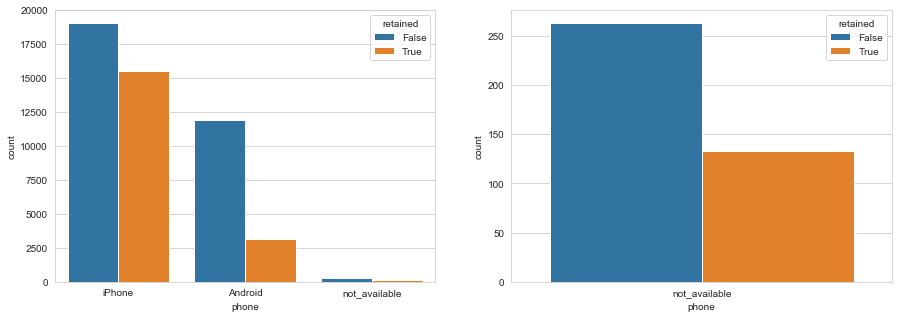

In [25]:
# correlation between 'retained' and 'phone'
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
sns.countplot(x='phone', data=user, hue='retained',ax=ax1);
ax2 = plt.subplot(1,2,2)
sns.countplot(x='phone', data=user[user.phone == 'not_available'], hue='retained',ax=ax2);

As shown, user retention is strongly correlated to the type of phone used by the user:<br> iphone users show a much higher retention rate (44.9%) than Android users (20.9%), whereas for users with no phone informaiton available, the rate is in the middle (33.6%).

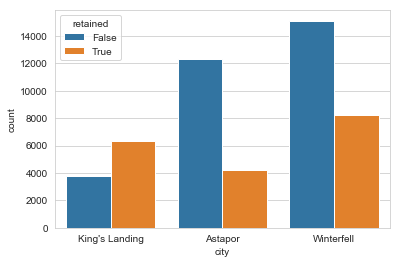

In [26]:
# correlation between 'retained' and 'city'
sns.countplot(x='city', data=user, hue='retained');

As shown, user retention is also strongly correlated to the city the user signed up in:<br> King's landing gives the highest retention rate among the three cities, whereas Astapor is the lowest. 

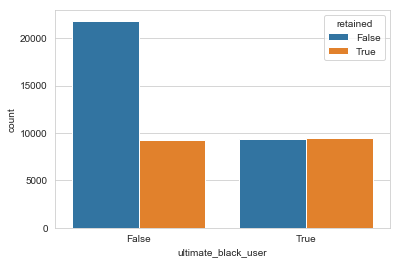

In [27]:
# correlation between 'retained' and 'city'
sns.countplot(x='ultimate_black_user', data=user, hue='retained');

As shown, user retention also correlates to whether a user is an 'ultimate black user':<br> 
Ultimate black users have a higher retention rate than non ultimate black users.

### 4.2 Correlation of user retention with numerical columns

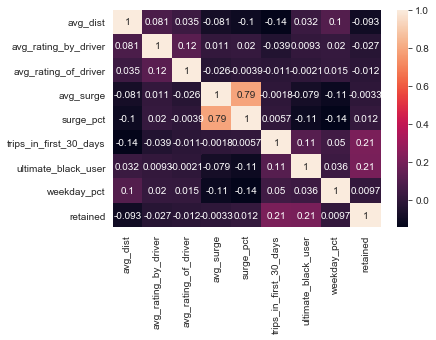

In [28]:
sns.heatmap(user.corr(),annot=True);

As shown, among the numerical columns, 'trips_in_first_30_days' shows the most positive correlations whereas the 'avg_dist' shows the most negative correlations.<br>
There are several numerical columns only showing minor correlations, including 'avg_rating_by_driver' and 'avg_rating_of_driver' columns. Therefore, we will simply use the median of those two columns to impute the missing values.

### 4.3 Correlation of user retention with datetime columns

signup_date
0    0.387984
1    0.376073
2    0.376645
3    0.360115
4    0.370533
5    0.380453
6    0.384687
Name: retained, dtype: float64


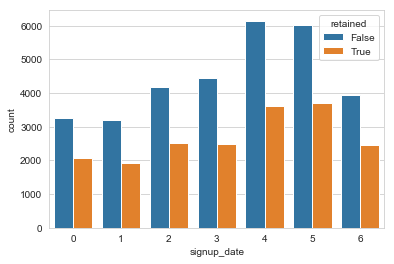

In [29]:
# correlation between 'retained' and 'day of the week' the user signed up
sns.countplot(x=user.signup_date.dt.dayofweek, data=user, hue='retained');
print(user.groupby(user.signup_date.dt.dayofweek)['retained'].mean())

signup_date
1    0.413005
2    0.377241
3    0.358766
4    0.374445
5    0.370746
Name: retained, dtype: float64


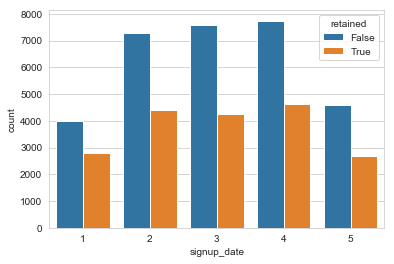

In [30]:
# correlation between 'retained' and 'week of the month' the user signed up
sns.countplot(x=user.signup_date.dt.week, data=user, hue='retained');
print(user.groupby(user.signup_date.dt.week)['retained'].mean())

# add 'signup_week' as a new featue and drop the original 'signup_date' column
user['signup_week'] = user.signup_date.dt.week.astype('category')
user = user.drop('signup_date',axis=1)

As show, there is little correlation between user retention and on which day of the week they signed up. Therefore, this feature is not added.<br>
On the other hand, a minor correlation is observed between user retention and on which week of January they signed up, therefore this is added a new feature, and the original 'signup_date' column is dropped. 

last_trip_date
0    0.438352
1    0.381611
2    0.328779
3    0.340780
4    0.359635
5    0.371874
6    0.389008
Name: retained, dtype: float64


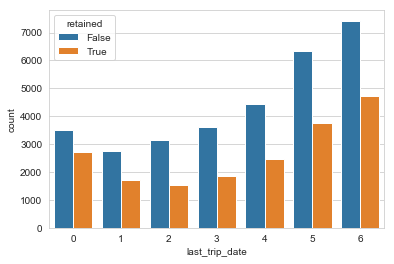

In [31]:
# correlation between 'retained' and 'day of the week' the user's last trip is
sns.countplot(x=user.last_trip_date.dt.dayofweek, data=user, hue='retained');
print(user.groupby(user.last_trip_date.dt.dayofweek)['retained'].mean())

# add 'lasttrip_dayofweek' as a new featue
user['lasttrip_dayofweek'] = user.last_trip_date.dt.dayofweek.astype('category')

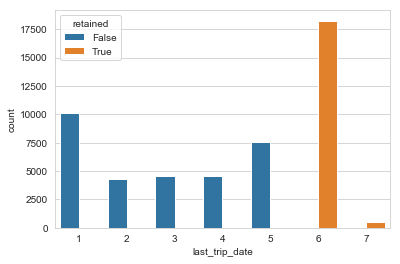

In [32]:
# correlation between 'retained' and the month the user's last trip is
sns.countplot(x=user.last_trip_date.dt.month, data=user, hue='retained');
# drop the original 'last_trip_date' column
user = user.drop('last_trip_date',axis=1)

As show, there is a minor correlation is observed between user retention and on which day of the week the user's last trip occurs, therefore this is added a new feature.<br>
On the other hand, the user retention is totally correlated to the month of the last trip as expected, since the the 'retained' user is identified based on their last trip date being 2014-06-01 and after. Therefore, this feature is not added and the original 'last_trip_date' column is dropped.

## 5. Modeling

To predict user adoption of the product, four different classification algorithms are experimented: 
1. linear Logistic Regression classification algorithm
2. non-linear Support Vector Machine classification algorithm
3. ensembles of tree-based Random Forest classification algorithm 
4. ensembles of tree-based Gradient Boosting classification algorithm

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 5.1 Setup

In [34]:
# impute missing values in 'avg_rating_by_driver' and 'avg_rating_of_driver' columns
user['avg_rating_by_driver'] = user.avg_rating_by_driver.fillna(user.avg_rating_by_driver.median())
user['avg_rating_of_driver'] = user.avg_rating_of_driver.fillna(user.avg_rating_of_driver.median())

In [35]:
# extract features X and target variable y
X = pd.get_dummies(user.drop('retained',axis=1), drop_first=True)
y = user.retained

X.head(2)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,...,signup_week_2,signup_week_3,signup_week_4,signup_week_5,lasttrip_dayofweek_1,lasttrip_dayofweek_2,lasttrip_dayofweek_3,lasttrip_dayofweek_4,lasttrip_dayofweek_5,lasttrip_dayofweek_6
0,3.67,5.0,4.7,1.1,15.4,4,True,46.2,1,0,...,0,0,1,0,1,0,0,0,0,0
1,8.26,5.0,5.0,1.0,0.0,0,False,50.0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [36]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [37]:
# initiate the score table
index = ['LogisticRegression','SVC','RandomForestClassifier','GradientBoostingClassifier']
score_table = pd.DataFrame(index = index, columns= ['accuracy_train','f1_score_train','accuracy_test','f1_score_test'])

# define function for plotting the results
def compute_log_result(algo, pred_train, pred_test):
    """compute and log the performance for both training and test sets"""
    
    # compute the performance  
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    # log the performance
    score_table.loc[algo,:] = accuracy_train, f1_train, accuracy_test, f1_test
    
    # compute confusion matrix and print
    print("Classification results based on the testset:\n", classification_report(y_test, pred_test))

### 5.2 Prototyping with default parameters

In [38]:
# fit logistic regression model with default parameters

logit = Pipeline([('scaler', StandardScaler()),('logit',LogisticRegression())])
logit.fit(X_train, y_train)
pred_train = logit.predict(X_train)
pred_test = logit.predict(X_test)

# logging of model performance
compute_log_result("LogisticRegression", pred_train, pred_test)

Classification results based on the testset:
              precision    recall  f1-score   support

      False       0.74      0.85      0.79      7799
       True       0.67      0.50      0.57      4701

avg / total       0.71      0.72      0.71     12500



In [39]:
# fit support vector machine model with default parameters

svc = Pipeline([('scaler', StandardScaler()),('svc', SVC())])
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

# logging of model performance
compute_log_result("SVC", pred_train, pred_test)

Classification results based on the testset:
              precision    recall  f1-score   support

      False       0.78      0.86      0.82      7799
       True       0.72      0.59      0.65      4701

avg / total       0.76      0.76      0.75     12500



In [40]:
# fit random forest model with default parameters

rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(class_weight='balanced'))]) # set class_weight='balanced' to adjust for the imbalanced classes
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

compute_log_result("RandomForestClassifier", pred_train, pred_test)

Classification results based on the testset:
              precision    recall  f1-score   support

      False       0.78      0.86      0.82      7799
       True       0.72      0.59      0.65      4701

avg / total       0.75      0.76      0.75     12500



In [41]:
# fit gradientboosting model with default parameters

gbc = Pipeline([('scaler', StandardScaler()),('gbc', GradientBoostingClassifier())]) # set class_weight='balanced' to adjust for the imbalanced classes
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

compute_log_result("GradientBoostingClassifier", pred_train, pred_test)

Classification results based on the testset:
              precision    recall  f1-score   support

      False       0.81      0.86      0.84      7799
       True       0.74      0.67      0.70      4701

avg / total       0.79      0.79      0.79     12500



In [42]:
print(score_table)

                           accuracy_train f1_score_train accuracy_test  \
LogisticRegression                0.72232       0.576828       0.71928   
SVC                              0.780507       0.677885       0.75896   
RandomForestClassifier           0.982827       0.976786       0.75776   
GradientBoostingClassifier       0.788507       0.702992       0.78888   

                           f1_score_test  
LogisticRegression              0.570659  
SVC                             0.647066  
RandomForestClassifier          0.646592  
GradientBoostingClassifier      0.704843  


### 5.3 Optimization
As shown, with the default parameters, GradientBoostingClassifier gives the best performance among the three. Therefore, parameter tuning of the GradientBoostingClassifier model is further performed using gridsearch cross validation.

In [48]:
# Grid search optimization of GradientBoostingClassifier

# Grid search of parameters n_estimators and max_features to improve GradientBoostingClassifer model
parameters = {'gbc__n_estimators': np.arange(500,1000,100), 'gbc__max_features':[None,'sqrt','log2']}
gbc_cv = GridSearchCV(gbc, parameters, scoring='accuracy', cv=5)
gbc_cv.fit(X_train, y_train)
print('Best parameters:', gbc_cv.best_params_)
print('Corresponding accuracy score:', gbc_cv.best_score_)

Best parameters: {'gbc__max_features': 'sqrt', 'gbc__n_estimators': 700}
Corresponding accuracy score: 0.7912266666666666


In [49]:
# updated GradientBoostingClassifier model with the optimized parameter
gbc = Pipeline([('scaler', StandardScaler()),('gbc', GradientBoostingClassifier(n_estimators=700, max_features='sqrt'))])
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

compute_log_result("GradientBoostingClassifier", pred_train, pred_test)

Classification results based on the testset:
              precision    recall  f1-score   support

      False       0.81      0.87      0.84      7799
       True       0.75      0.67      0.71      4701

avg / total       0.79      0.79      0.79     12500



In [50]:
# final results
print(score_table.loc['GradientBoostingClassifier'])

# feature importance ranking from the optimized GradientBoostingClassifier 
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbc.named_steps.gbc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

accuracy_train      0.8032
f1_score_train    0.723243
accuracy_test      0.79392
f1_score_test     0.710757
Name: GradientBoostingClassifier, dtype: object
                   feature  importance
7              weekday_pct    0.160749
5   trips_in_first_30_days    0.145351
0                 avg_dist    0.121783
4                surge_pct    0.098709
1     avg_rating_by_driver    0.093130
3                avg_surge    0.090360
2     avg_rating_of_driver    0.069615
8      city_King's Landing    0.043062
6      ultimate_black_user    0.022774
9          city_Winterfell    0.021621
10            phone_iPhone    0.021345
18    lasttrip_dayofweek_3    0.013887
21    lasttrip_dayofweek_6    0.013761
20    lasttrip_dayofweek_5    0.013165
19    lasttrip_dayofweek_4    0.013137
13           signup_week_3    0.012644
12           signup_week_2    0.008701
17    lasttrip_dayofweek_2    0.008014
11     phone_not_available    0.007638
15           signup_week_5    0.007446
16    lasttrip_dayofweek_

As shown, the optimized GradientBoostingClassifier gives the best accuracy score and F1 score among all. The feature ranking from the optimized classifier suggests that athe percent of weekday trips('weekday_pct'), trips taken in the first 30 days of signing up ('trips_in_first_30_days') and average trip distance ('avg_dist') are the top three factors indicating user retention after 6 month of signing up. 

### 5.4 Client recommendation

To understand and improve long-term rider retention:<br>

1) Regular marketing email/outreach to users who take trips of intermediate distances, having the majority of their trips during weekdays, more than 2 trips during the first 30 days, and at least one trip of surge pricing, to make sure those who have needs and are likely to retain will indeed retain without dropping off. <br>
2) Have more marketing campaign and maybe consider offering discount/coupon/incentives in cities 'Winterfell' and 'Astapor' as those two cities see a much lower user retention rate than city 'King's landing'. <br> Further investigation on why King's landing is much more successful at retaining users might provide valuable insights. <br>
3) Investigate into why Android phone users show a significantly lower retention rate than iphone users. If part of the service involves the mobile app, this could suggest that the Android app might have bugs, or at least is not very user friendly.